In [6]:
import os
# Get the directory of the current script
try:
    current_directory = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_directory = os.getcwd()

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the sliding window data
file_path = r'C:\Users\Shadow\Desktop\GIT_X\GIT_PE\thesis\V2\Sliding Window\modi_data.csv'
data = pd.read_csv(file_path)

# Step 1: Identify and clean non-numeric values
# Replace problematic non-numeric values with NaN and convert to float
data = data.apply(pd.to_numeric, errors='coerce')

# Step 2: Drop rows with NaN values
data = data.dropna()

# Preprocess the data
scaler = StandardScaler()
X = scaler.fit_transform(data.iloc[:, :-1])  # Features
y = scaler.fit_transform(data.iloc[:, -1].values.reshape(-1, 1))  # Target

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the N-Beats Block and Model
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, hidden_size, theta_size):
        super(NBeatsBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, theta_size)  # Only output theta_size (forecasting steps)
        )
        self.backcast_size = input_size
        self.forecast_size = theta_size

    def forward(self, x):
        theta = self.fc(x)
        return theta  # Return only forecast

class NBeatsModel(nn.Module):
    def __init__(self, input_size, hidden_size, theta_size, num_blocks):
        super(NBeatsModel, self).__init__()
        self.blocks = nn.ModuleList([NBeatsBlock(input_size, hidden_size, theta_size) for _ in range(num_blocks)])
    
    def forward(self, x):
        forecast = torch.zeros(x.shape[0], 1).to(x.device)  # Initialize forecast shape [batch_size, 1]
        for block in self.blocks:
            f = block(x)  # No backcast subtraction, only forecast aggregation
            forecast = forecast + f  # Aggregate forecasts
        return forecast

# Model parameters
input_size = X_train.shape[1]  # Number of features
hidden_size = 256  # Hidden layer size
theta_size = 1  # Output size for forecasting (single future value)
num_blocks = 3  # Number of blocks in the model

# Initialize the model
model = NBeatsModel(input_size=input_size, hidden_size=hidden_size, theta_size=theta_size, num_blocks=num_blocks)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_loss = 0.0
    all_preds = []
    all_targets = []
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()
        all_preds.extend(y_pred.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

    print(f'Test Loss (MSE): {test_loss / len(test_loader):.4f}')

# Calculate Evaluation Metrics
all_preds = np.array(all_preds).flatten()
all_targets = np.array(all_targets).flatten()

mae = mean_absolute_error(all_targets, all_preds)
mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
r2 = r2_score(all_targets, all_preds)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² (R-squared): {r2:.4f}')

# Make predictions and save to CSV
with torch.no_grad():
    future_forecast = model(X_test_tensor)
    future_forecast = scaler.inverse_transform(future_forecast.numpy())  # Inverse scale

    # Convert to DataFrame
    forecast_df = pd.DataFrame(future_forecast, columns=["Forecast"])

    # Save to CSV
    forecast_df.to_csv('future_forecast.csv', index=False)

    print(f"Predictions saved to 'future_forecast.csv'")


C:\Users\Shadow\AppData\Local\Temp\ipykernel_24404\2113940937.py:12: DtypeWarning: Columns (7,11,18,19,37,41,48,49,67,71,78,79,97,101,108,109) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Epoch [0/100], Loss: 0.2462
Epoch [10/100], Loss: 0.1366
Epoch [20/100], Loss: 0.0840
Epoch [30/100], Loss: 0.0633
Epoch [40/100], Loss: 0.0372
Epoch [50/100], Loss: 0.0318
Epoch [60/100], Loss: 0.0206
Epoch [70/100], Loss: 0.0182
Epoch [80/100], Loss: 0.0251
Epoch [90/100], Loss: 0.0203
Test Loss (MSE): 0.1434
Mean Absolute Error (MAE): 0.2537
Mean Squared Error (MSE): 0.1434
Root Mean Squared Error (RMSE): 0.3787
R² (R-squared): 0.8217
Predictions saved to 'future_forecast.csv'


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the sliding window data
file_path = r'C:\Users\Shadow\Desktop\GIT_X\GIT_PE\thesis\V2\Sliding Window\modi_data.csv'
data = pd.read_csv(file_path)

# Step 1: Identify and clean non-numeric values
# Replace problematic non-numeric values with NaN and convert to float
data = data.apply(pd.to_numeric, errors='coerce')

# Step 2: Drop rows with NaN values
data = data.dropna()

# Preprocess the data
scaler = StandardScaler()
X = scaler.fit_transform(data.iloc[:, :-1])  # Features
y = scaler.fit_transform(data.iloc[:, -1].values.reshape(-1, 1))  # Target

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the N-Beats Block and Model
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, hidden_size, theta_size):
        super(NBeatsBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, theta_size)  # Only output theta_size (forecasting steps)
        )
        self.backcast_size = input_size
        self.forecast_size = theta_size

    def forward(self, x):
        theta = self.fc(x)
        return theta  # Return only forecast

class NBeatsModel(nn.Module):
    def __init__(self, input_size, hidden_size, theta_size, num_blocks):
        super(NBeatsModel, self).__init__()
        self.blocks = nn.ModuleList([NBeatsBlock(input_size, hidden_size, theta_size) for _ in range(num_blocks)])
    
    def forward(self, x):
        forecast = torch.zeros(x.shape[0], 1).to(x.device)  # Initialize forecast shape [batch_size, 1]
        for block in self.blocks:
            f = block(x)  # No backcast subtraction, only forecast aggregation
            forecast = forecast + f  # Aggregate forecasts
        return forecast

# Model parameters
input_size = X_train.shape[1]  # Number of features
hidden_size = 256  # Hidden layer size
theta_size = 1  # Output size for forecasting (single future value)
num_blocks = 3  # Number of blocks in the model

# Initialize the model
model = NBeatsModel(input_size=input_size, hidden_size=hidden_size, theta_size=theta_size, num_blocks=num_blocks)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_loss = 0.0
    all_preds = []  
    all_targets = []  
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()
        all_preds.extend(y_pred.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

    print(f'Test Loss (MSE): {test_loss / len(test_loader):.4f}')

# Calculate Evaluation Metrics
all_preds = np.array(all_preds).flatten()
all_targets = np.array(all_targets).flatten()

mae = mean_absolute_error(all_targets, all_preds)
mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
r2 = r2_score(all_targets, all_preds)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R² (R-squared): {r2:.4f}')

# Make predictions and save to CSV
with torch.no_grad():
    future_forecast = model(X_test_tensor)
    future_forecast = scaler.inverse_transform(future_forecast.numpy())  # Inverse scale

    # Convert to DataFrame
    forecast_df = pd.DataFrame(future_forecast, columns=["Forecast"])

    # Save to CSV
    forecast_df.to_csv('future_forecast.csv', index=False)

    print(f"Predictions saved to 'future_forecast.csv'")


C:\Users\Shadow\AppData\Local\Temp\ipykernel_24404\3208885584.py:12: DtypeWarning: Columns (7,11,18,19,37,41,48,49,67,71,78,79,97,101,108,109) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Epoch [0/100], Loss: 0.2632
Epoch [10/100], Loss: 0.1288
Epoch [20/100], Loss: 0.0951
Epoch [30/100], Loss: 0.0636
Epoch [40/100], Loss: 0.0500
Epoch [50/100], Loss: 0.0408
Epoch [60/100], Loss: 0.0293
Epoch [70/100], Loss: 0.0165
Epoch [80/100], Loss: 0.0172
Epoch [90/100], Loss: 0.0187
Test Loss (MSE): 0.1535
Mean Absolute Error (MAE): 0.2589
Mean Squared Error (MSE): 0.1535
Root Mean Squared Error (RMSE): 0.3918
R² (R-squared): 0.8091
Predictions saved to 'future_forecast.csv'


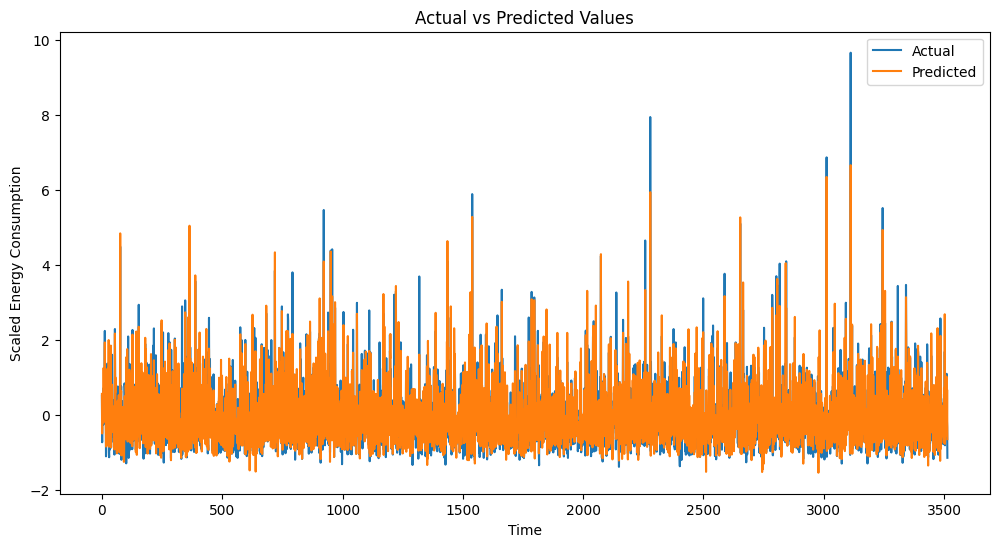

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(all_targets, label='Actual')
plt.plot(all_preds, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Scaled Energy Consumption')
plt.title('Actual vs Predicted Values')
plt.legend()

output_bar_chart_path = os.path.join(current_directory, 'Actual vs Predicted Values.png')
plt.savefig(output_bar_chart_path, bbox_inches='tight')

plt.show()
